# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "novel taxa". Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy of "novel taxa" are different from those used for mock and simulated communities.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: assignment == L - 1 (e.g., a novel species is assigned the correct genus)
    * overclassification: assignment == L (e.g., correct genus but assigns to a near neighbor)
    * misclassification: incorrect assignment at L - 1 (e.g., wrong genus-level assignment)
    
Where ``L`` = taxonomic level being tested




## Functions

In [1]:
from tax_credit.framework_functions import novel_taxa_classification_evaluation
from tax_credit.eval_framework import parameter_comparisons
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           rank_optimized_method_performance_by_dataset)

from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display, Markdown
import pandas as pd

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = "../.."
analysis_name = "novel-taxa-simulations"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
force = False
if force or not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**Precision** = Proportion of classifications that were correct. For novel taxa, this means a match at the last common ancestor (LCA) (level-1). True Positives / (True Positives + False Positives)

**Recall** = Proportion of reads that were correctly classified. Equals the number of exact matches to the LCA. True Positives / (True Positives + False Negatives)

**F-measure** = Harmonic mean of Precision and Recall

**overclassification_ratio** = proportion of taxa that were assigned to correct lineage but to a deeper taxonomic level than expected, rather than to LCA. E.g., assignment to another species in the clade

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_pallette={
    'rdp': 'seagreen', 'sortmerna': 'gray', 'vsearch': 'brown',
    'uclust': 'blue', 'blast': 'black', 'blast+': 'purple', 'q2-nb': 'pink',
    'naive-bayes': 'orange'
}

y_vars = ["Precision", "Recall", "F-measure",
          "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

## Plot per-level classification accuracy

For novel-taxa analysis, a separate classification is performed at each taxonomic level using different test (unique taxa at level L) and training sets (ref - test taxonomies). Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species. 

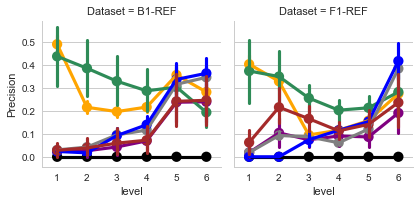

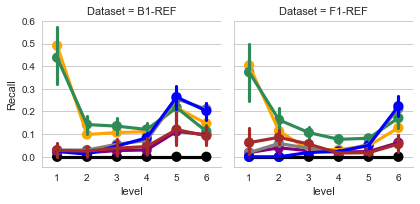

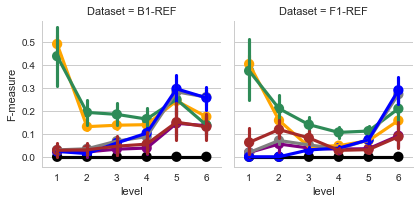

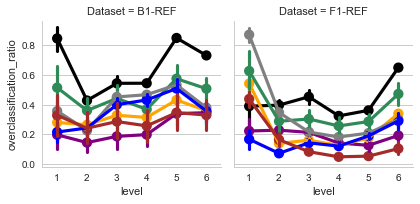

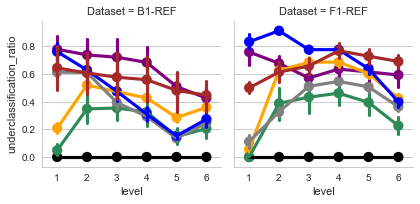

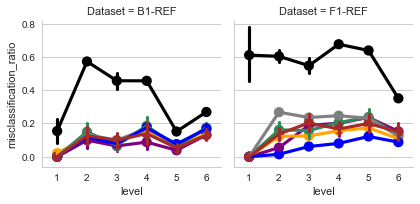

In [5]:
pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Naive-Bayes k-mer length picker

In [6]:
from pandas import DataFrame, concat, to_numeric

In [7]:
nb_results = accuracy_results[accuracy_results['Method'] == 'naive-bayes']
nb_results = nb_results.reset_index(drop=True)
columns = ['Alpha', 'kmer', 'Confidence']
def decode_params(p):
    p = p.split(':')
    p[-2] = int(eval(p[-2])[0])
    return p
params = DataFrame((decode_params(s) for s in nb_results['Parameters']), columns=columns)
keepers = ['Dataset', 'level', 'Method']
metrics = y_vars
raw_param_results = concat([nb_results[keepers + metrics], params], axis=1)
raw_param_results = raw_param_results.apply(to_numeric, errors='ignore')
param_results = raw_param_results.groupby(keepers + columns, as_index=False).mean()
param_results.level = param_results.level.astype(int)
param_results.kmer = param_results.kmer.astype(int)
len(param_results)

1296

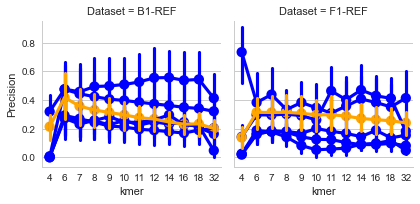

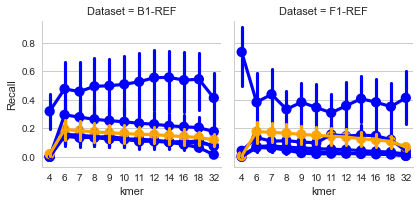

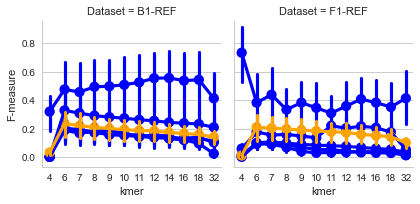

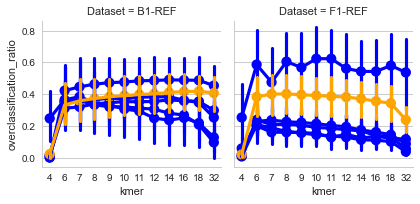

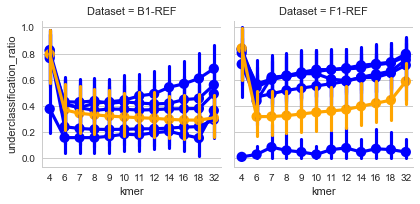

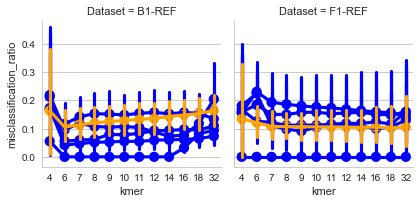

In [8]:
level_pallete = {n:'blue' for n in range(1,6)}
level_pallete[6] = 'orange'
pointplot_from_data_frame(param_results, "kmer", y_vars, 
                          group_by="Dataset", color_by="level",
                          color_pallette=level_pallete)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [20]:
result = per_level_kruskal_wallis(accuracy_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Dataset,Variable,1,2,3,4,5,6
0,B1-REF,Precision,8.241441e-46,8.822214e-25,9.259168e-15,5.969736e-15,2.506888e-05,1.357682e-07
1,B1-REF,Recall,8.241441e-46,2.041312e-22,3.837822e-13,4.403113e-14,4.326535e-08,5.267536e-15
2,B1-REF,F-measure,8.241441e-46,2.735165e-23,8.656979e-14,1.637687e-14,2.646422e-07,1.806480e-13
3,B1-REF,overclassification_ratio,4.326535e-08,4.884334e-05,4.853095e-10,3.076997e-16,3.194018e-08,3.006092e-07
4,B1-REF,underclassification_ratio,1.585365e-54,1.037442e-10,1.160336e-09,7.272181e-10,9.051610e-13,1.039314e-09
5,B1-REF,misclassification_ratio,3.622453e-16,2.393009e-07,6.867733e-08,1.028754e-11,3.678470e-14,7.280989e-06
6,F1-REF,Precision,8.044413e-40,9.955331e-20,7.218849e-10,1.265124e-09,6.464274e-08,4.514306e-10
7,F1-REF,Recall,8.044413e-40,2.209889e-17,4.254808e-13,4.404391e-09,2.568263e-10,2.024411e-14
8,F1-REF,F-measure,8.044413e-40,1.954399e-18,4.671006e-12,1.758706e-08,1.939320e-09,1.801307e-14
9,F1-REF,overclassification_ratio,4.223413e-28,4.559576e-38,3.665587e-15,1.193339e-20,9.964955e-17,3.613000e-15


## Heatmaps of method accuracy by parameter
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal novel-taxa datasets individually).

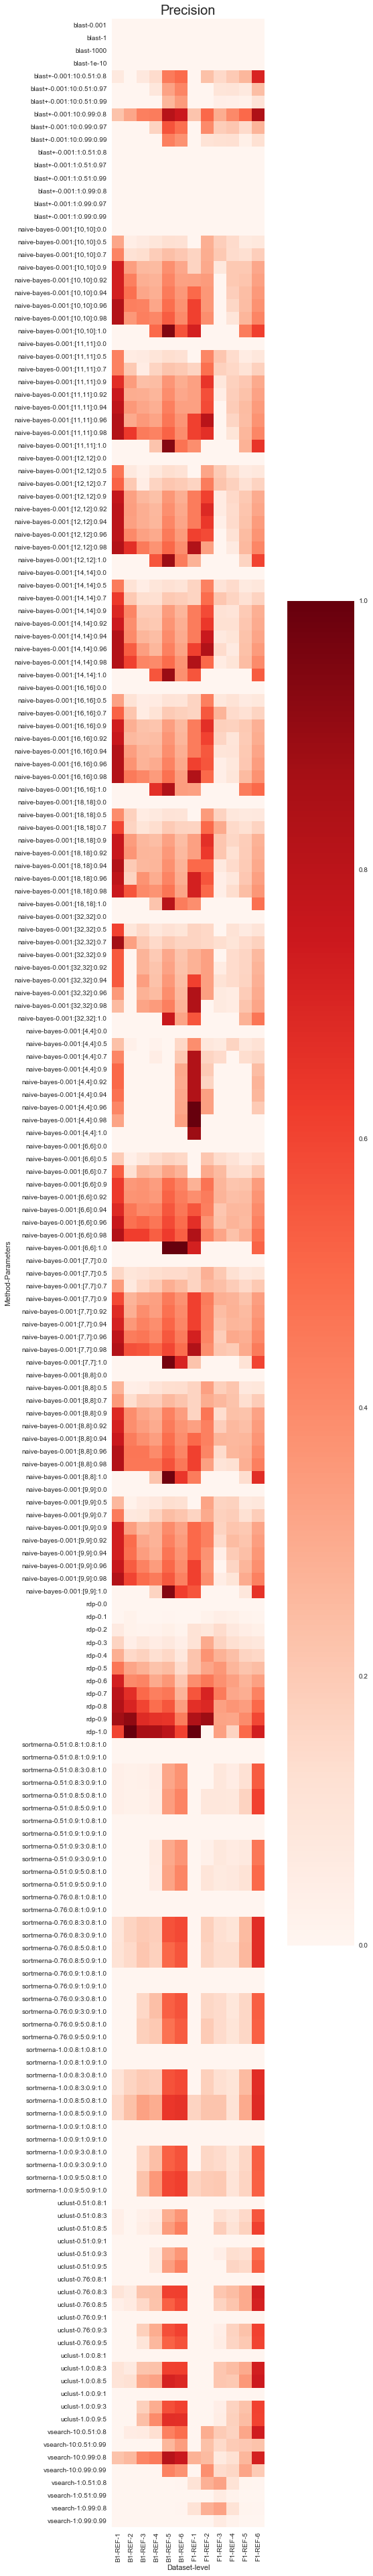

In [21]:
heatmap_from_data_frame(accuracy_results, metric="Precision", rows=["Method", "Parameters"], cols=["Dataset", "level"])

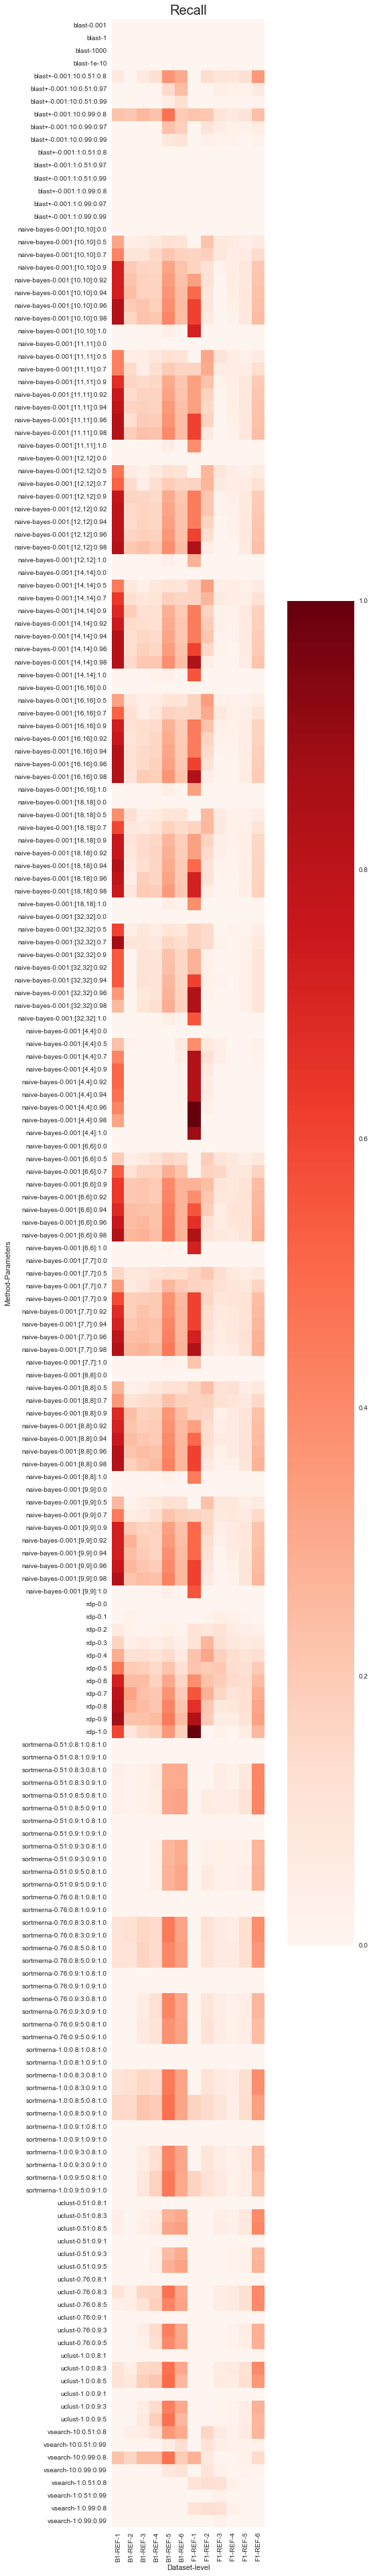

In [22]:
heatmap_from_data_frame(accuracy_results, metric="Recall", rows=["Method", "Parameters"], cols=["Dataset", "level"])

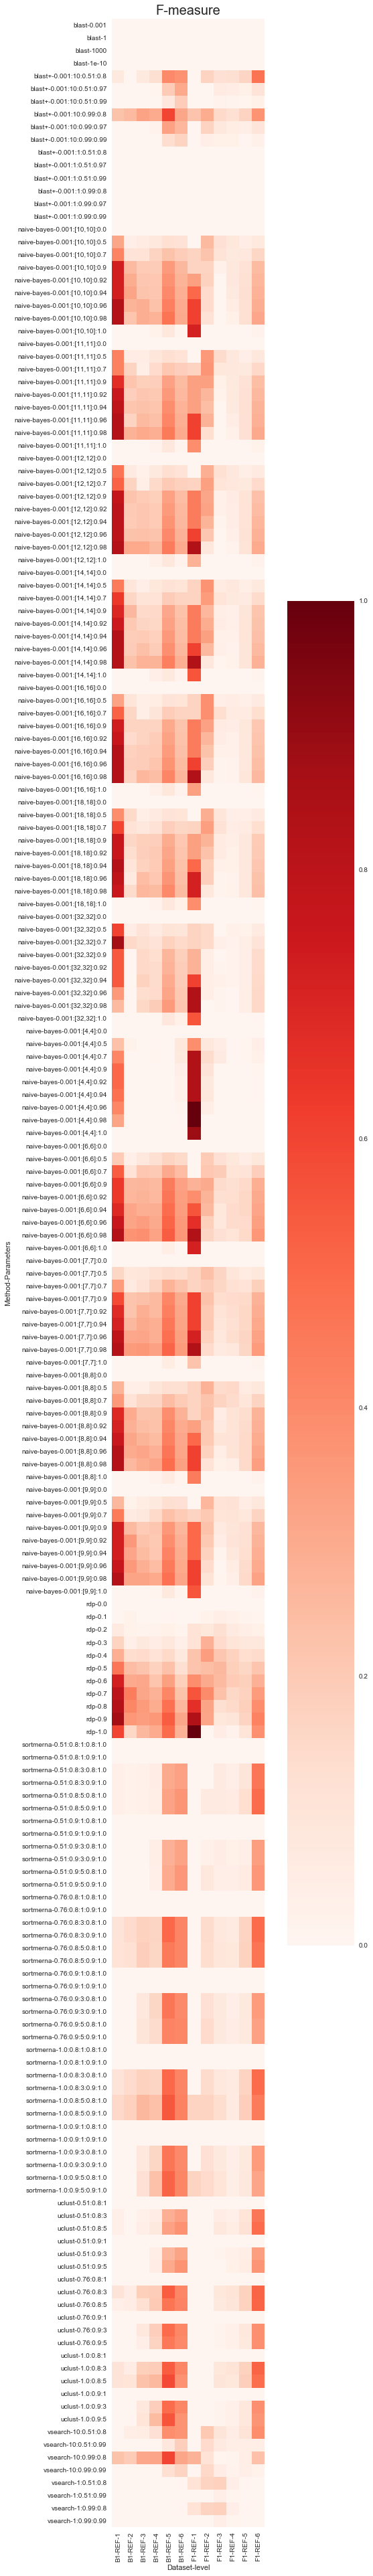

In [23]:
heatmap_from_data_frame(accuracy_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Dataset", "level"])

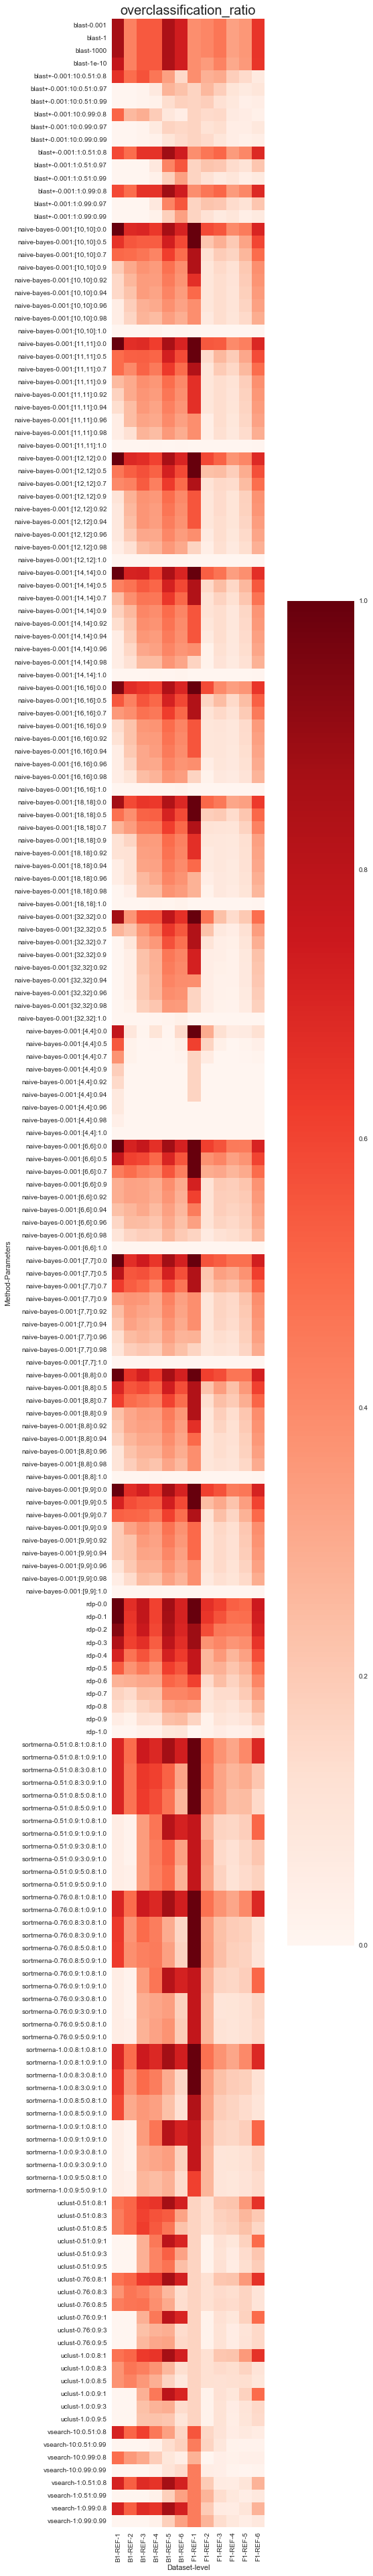

In [24]:
heatmap_from_data_frame(accuracy_results, metric="overclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

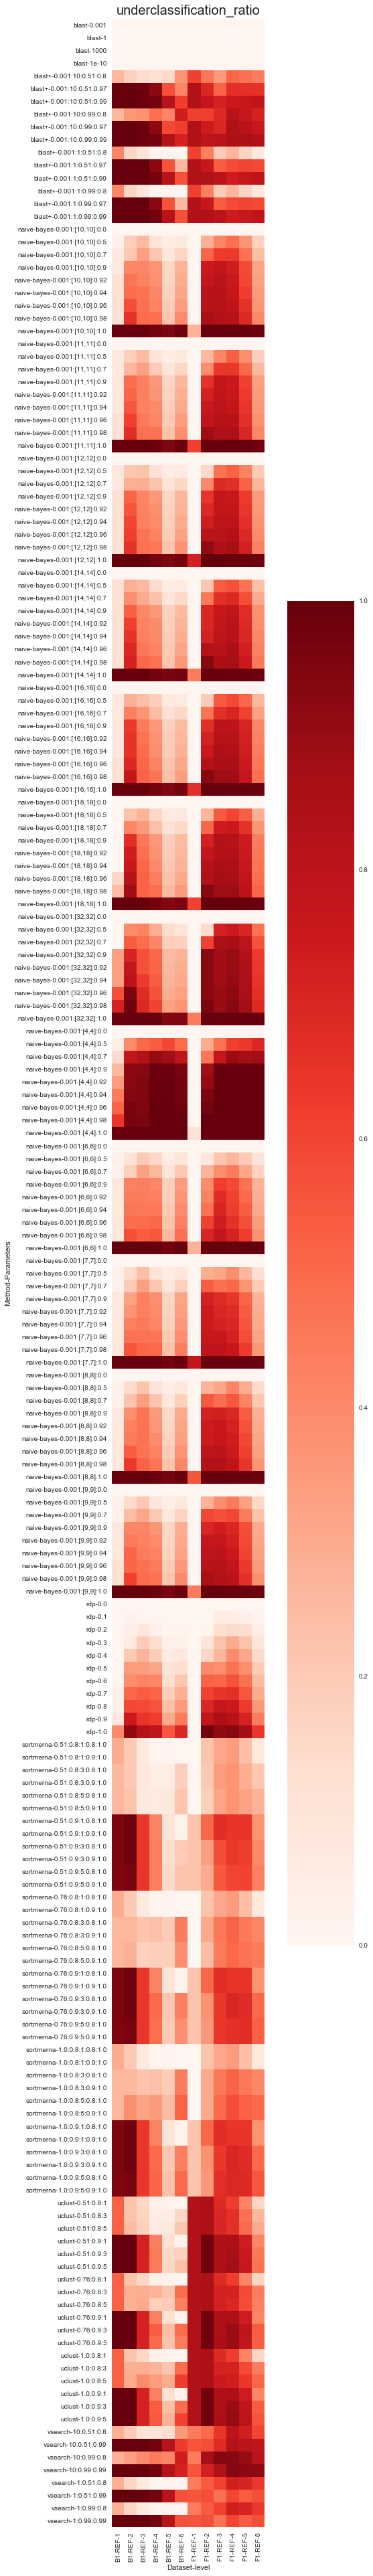

In [25]:
heatmap_from_data_frame(accuracy_results, metric="underclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

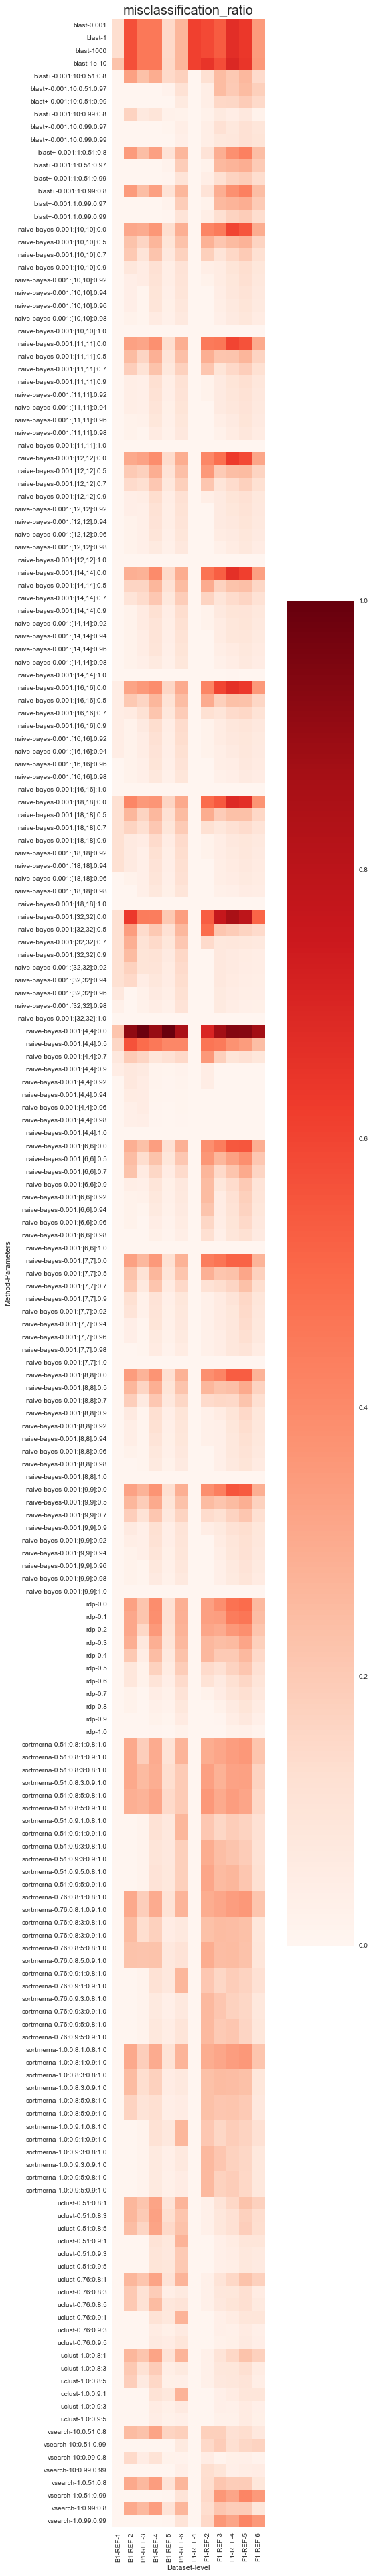

In [26]:
heatmap_from_data_frame(accuracy_results, metric="misclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [27]:
for method in accuracy_results['Method'].unique():
    top_params = parameter_comparisons(accuracy_results[accuracy_results["level"] == 6], 
                                       method, metrics=["Precision", "Recall", 
                                                        "overclassification_ratio", 
                                                        "underclassification_ratio", 
                                                        "misclassification_ratio",
                                                        "F-measure"],
                                       ascending={"Precision": False, "Recall": False, 
                                                        "overclassification_ratio": True, 
                                                        "underclassification_ratio": True, 
                                                        "misclassification_ratio": True,
                                                        "F-measure": False},
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## blast

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
0.001,6,6,6,2,1,6
1,6,6,6,2,1,6
1000,6,6,6,2,1,6
1e-10,6,6,6,2,2,6


## blast+

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
0.001:10:0.51:0.8,6.0,3.0,6.0,0.0,6.0,0.0
0.001:10:0.99:0.8,4.0,6.0,1.0,6.0,6.0,0.0
0.001:10:0.51:0.97,3.0,0.0,3.0,0.0,6.0,0.0
0.001:10:0.99:0.97,1.0,1.0,1.0,3.0,6.0,0.0
0.001:10:0.51:0.99,0.0,0.0,0.0,3.0,6.0,0.0


## naive-bayes

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
"0.001:[6,6]:0.94",6.0,0.0,6.0,4.0,0.0,0.0
"0.001:[6,6]:0.9",6.0,0.0,6.0,2.0,0.0,0.0
"0.001:[7,7]:0.96",6.0,0.0,6.0,5.0,0.0,0.0
"0.001:[12,12]:0.98",6.0,0.0,6.0,5.0,0.0,0.0
"0.001:[6,6]:0.92",6.0,0.0,6.0,2.0,0.0,0.0


## rdp

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
0.8,6.0,0.0,6.0,6.0,2.0,0.0
0.9,6.0,3.0,6.0,6.0,6.0,0.0
1.0,6.0,6.0,5.0,6.0,6.0,0.0
0.7,4.0,0.0,6.0,4.0,0.0,0.0
0.6,1.0,0.0,4.0,0.0,0.0,0.0


## sortmerna

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
1.0:0.8:3:0.9:1.0,6.0,6.0,6.0,6.0,6.0,0.0
0.51:0.9:5:0.8:1.0,6.0,3.0,4.0,0.0,6.0,0.0
0.76:0.9:3:0.8:1.0,6.0,6.0,3.0,6.0,6.0,0.0
1.0:0.8:5:0.9:1.0,6.0,6.0,6.0,6.0,6.0,0.0
0.76:0.8:5:0.9:1.0,6.0,6.0,6.0,5.0,6.0,0.0


## uclust

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
1.0:0.9:5,6.0,6.0,4.0,6.0,6.0,0.0
1.0:0.8:3,6.0,6.0,6.0,6.0,6.0,0.0
0.51:0.8:5,6.0,3.0,6.0,0.0,6.0,0.0
1.0:0.9:3,6.0,6.0,6.0,6.0,6.0,0.0
0.51:0.9:5,6.0,3.0,6.0,3.0,6.0,0.0


## vsearch

,F-measure,Precision,Recall,misclassification_ratio,overclassification_ratio,underclassification_ratio
10:0.51:0.8,6.0,3.0,5.0,3,6.0,2.0
10:0.99:0.8,3.0,6.0,1.0,6,6.0,0.0
10:0.51:0.99,0.0,0.0,0.0,3,6.0,0.0
10:0.99:0.99,0.0,0.0,0.0,6,6.0,0.0
1:0.51:0.8,0.0,0.0,0.0,3,0.0,6.0


## Rank performance of optimized methods
Now we rank the top-performing method/parameter combination for each method at species level. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## B1-REF level 6

,Method,Parameters,Precision,Recall,F-measure,overclassification_ratio,underclassification_ratio,misclassification_ratio
4,sortmerna,1.0:0.8:5:0.8:1.0,0.655971,0.312642,0.423304,0.117930,0.518544,0.050884
5,uclust,0.76:0.8:5,0.588096,0.325494,0.418949,0.136205,0.434570,0.103731
1,blast+,0.001:10:0.51:0.8,0.498477,0.304266,0.377878,0.149445,0.366501,0.178379
6,vsearch,10:0.51:0.8,0.486433,0.298671,0.370055,0.163164,0.354123,0.183104
2,naive-bayes,"0.001:[6,6]:0.98",0.523562,0.270338,0.356546,0.201494,0.482492,0.045675
3,rdp,0.9,0.440478,0.242460,0.312760,0.250488,0.447655,0.059397
0,blast,0.001,0.000000,0.000000,0.000000,0.730808,0.000000,0.269192


stat         P     FDR P
Method A    Method B                                   
blast       blast+      -135.974223  0.000054  0.001136
            naive-bayes  -25.811453  0.001498  0.004493
            rdp          -44.377598  0.000507  0.003238
            sortmerna    -64.010953  0.000244  0.002562
            uclust       -33.907064  0.000869  0.003648
            vsearch      -40.247951  0.000617  0.003238
blast+      naive-bayes    1.398946  0.296741  0.327977
            rdp            7.218273  0.018657  0.032650
            sortmerna     -5.346789  0.033245  0.049868
            uclust        -3.041175  0.093246  0.115187
            vsearch        0.847345  0.486032  0.510334
naive-bayes rdp            6.212151  0.024947  0.040299
            sortmerna     -3.707405  0.065669  0.091937
            uclust       -27.579518  0.001312  0.004493
            vsearch       -1.673140  0.236272  0.275650
rdp         sortmerna    -10.005599  0.009842  0.022964
            uclust       -17.282230  0.003331  0.008745
            vsearch       -8.673189  0.013034  0.026588
sortmerna   uclust         0.253685  0.823436  0.823436
            vsearch        3.457665  0.074426  0.097684
uclust      vsearch        8.384876  0.013927  0.026588

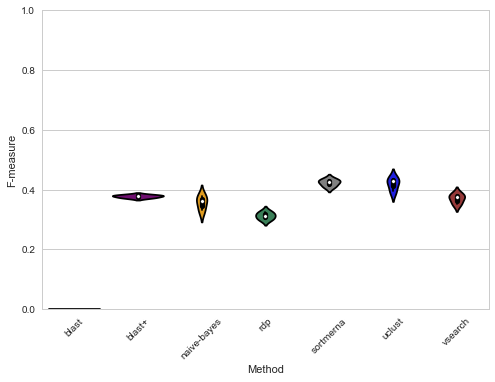

## F1-REF level 6

,Method,Parameters,Precision,Recall,F-measure,overclassification_ratio,underclassification_ratio,misclassification_ratio
5,uclust,1.0:0.8:3,0.727888,0.402913,0.518689,0.103166,0.438252,0.055670
4,sortmerna,1.0:0.8:3:0.9:1.0,0.675696,0.388649,0.493440,0.115928,0.408362,0.087061
1,blast+,0.001:10:0.51:0.8,0.703189,0.352098,0.469214,0.066806,0.440073,0.141023
3,rdp,0.9,0.592356,0.330554,0.424299,0.194068,0.438262,0.037116
6,vsearch,10:0.51:0.8,0.735864,0.268488,0.392185,0.056058,0.599296,0.076159
2,naive-bayes,"0.001:[6,6]:0.98",0.471703,0.290439,0.359483,0.268079,0.378700,0.062782
0,blast,0.001,0.000000,0.000000,0.000000,0.649630,0.000000,0.350370


stat         P     FDR P
Method A    Method B                                   
blast       blast+      -110.352684  0.000082  0.000340
            naive-bayes -131.720554  0.000058  0.000303
            rdp         -101.397926  0.000097  0.000340
            sortmerna   -167.028283  0.000036  0.000251
            uclust      -234.682138  0.000018  0.000191
            vsearch      -14.596769  0.004661  0.008156
blast+      naive-bayes   16.146794  0.003814  0.007281
            rdp            6.353974  0.023885  0.033439
            sortmerna     -4.604098  0.044079  0.057854
            uclust        -7.748338  0.016252  0.024377
            vsearch        3.382454  0.077394  0.085541
naive-bayes rdp          -24.123753  0.001714  0.003599
            sortmerna    -46.426124  0.000464  0.001391
            uclust      -251.502886  0.000016  0.000191
            vsearch       -1.107217  0.383540  0.391810
rdp         sortmerna    -38.144871  0.000687  0.001802
            uclust       -29.998664  0.001109  0.002589
            vsearch        1.083547  0.391810  0.391810
sortmerna   uclust        -8.414831  0.013830  0.022341
            vsearch        3.636451  0.067999  0.079332
uclust      vsearch        4.351320  0.048968  0.060490

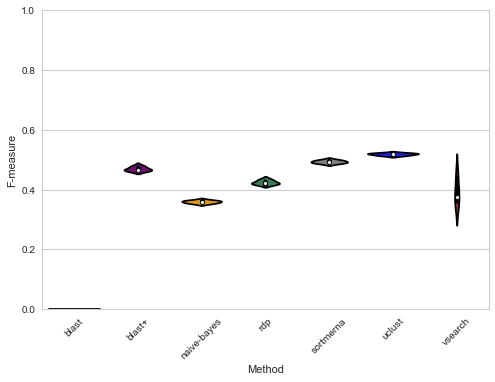

In [28]:
rank_optimized_method_performance_by_dataset(accuracy_results, dataset="Dataset",
                                             metric="F-measure",
                                             level="level",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure",
                                                             "overclassification_ratio",
                                                             "underclassification_ratio",
                                                             "misclassification_ratio"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)